### Clustering implementation
En esta sección se implementarán los métodos de clustering seleccionados previamente.
* `K-Means`
* `DBSCAN`
* `Gaussian Mixture Models (GMM)`
* `Hierarchical Clustering (Agglomerative)`

#### Scaling the data
Primero vamos a preparar los datos para utilizar los métodos de clustering.
Since different features may have different scales (e.g., `n_clicks` and `monto_compras`), it's important to scale the data so that all features are on a similar scale. This can be done using algún escalador from scikit-learn.
##### Escaladores
* StandardScaler: Para datos simétricos o con distribución normal.
* MinMaxScaler: Para datos con rangos definidos (e.g., \[0, 1\]) o distribuciones arbitrarias.
* RobustScaler: Para datos con outliers o distribuciones sesgadas.
* MaxAbsScaler: Para datos dispersos (sparse) con valores positivos y negativos.
* Normalizer: Para datos basados en vectores o magnitudes.
* PowerTransformer: Para datos altamente sesgados, para hacerlos más normales.
* QuantileTransformer: Para transformar datos a distribuciones uniformes o normales.
* Binarizer: Para convertir datos numéricos en valores binarios (0 y 1).

Debido a las distribuciones de las variables estudiadas en el análisis exploratorio, se utilizarán los siguientes escaladores:
* `n_clicks`: **MinMaxScaler**. Rango de valores amplio, se desea normalizar entre 0 y 1 para evitar que valores extremos afecten el clustering.
* `n_visitas`: **MinMaxScaler**. Similar a `n_clicks`, es necesario normalizar para que todos los valores estén en el mismo rango.
* `monto_compras`: **StandardScaler**. Como es una variable con distribución no uniforme, la normalización z-score ayudará a manejar mejor las diferencias en magnitudes y dispersión.
* `monto_descuentos`: **StandardScaler**. Al ser una variable continua con posibles valores extremos, la estandarización ayudará a tratar la dispersión y a darle una influencia más equilibrada en los algoritmos de clustering.
* `dias_primera_compra`: **MinMaxScaler**. Necesita ser escalada para ajustarse al rango \[0, 1\] y ser comparable con otras variables continuas.
* `info_perfil`: **StandardScaler**. Aunque es una variable ordinal, puede beneficiarse de la normalización z-score para darle un peso equilibrado sin que su rango desproporcione el clustering.

In [36]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [28]:
# Loading cleaned dataset
dataset_path = "../data/processed/cleaned_dataset.csv"
df = pd.read_csv(dataset_path)
df = df.drop(columns=["ID"])

In [29]:
# Util functions
def scale_minmax(df, column):
    scaler = MinMaxScaler()
    df[column] = scaler.fit_transform(df[[column]])

def scale_standard(df, column):
    scaler = StandardScaler()
    df[column] = scaler.fit_transform(df[[column]])

In [30]:
# Scaling variables
df_scaled = df.copy()
minmax = ["n_clicks", "n_visitas", "dias_primera_compra"]
standr = ["monto_compras", "monto_descuentos", "info_perfil"]
for i in minmax:
    scale_minmax(df_scaled, i)
for j in standr:
    scale_standard(df_scaled, j)

#### K_Means
Vamos a comenzar con la implementación de k_means.

##### Determining the number of clusters (K)
Once the data is scaled, we need to determine how many clusters we want to use. The optimal number of clusters can be determined using the **Elbow Method** or **Silhouette Score**.

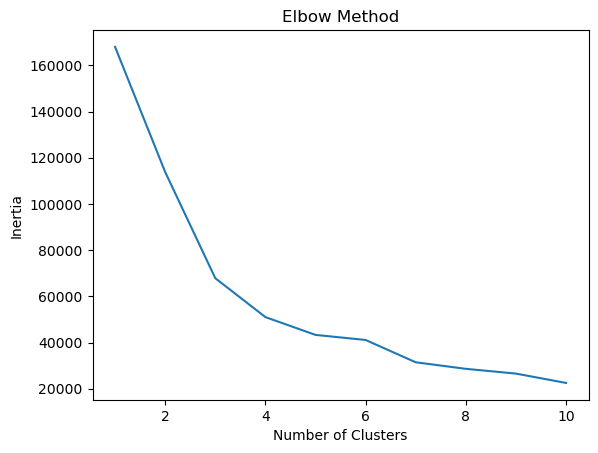

In [31]:
# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

**Silhouette score**
Con el siguiente código:
```python
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    print(f'K = {k}, Silhouette Score = {score}')
```
Se obtuvo la siguiente salida:
```python
K = 2,  Silhouette Score = 0.34845243698819506
K = 3,  Silhouette Score = 0.4590400127085664
K = 4,  Silhouette Score = 0.4320786610078347
K = 5,  Silhouette Score = 0.3958877304102838
K = 6,  Silhouette Score = 0.3731403430744861
K = 7,  Silhouette Score = 0.3649757438399236
K = 8,  Silhouette Score = 0.340390292589068
K = 9,  Silhouette Score = 0.351938358181696
K = 10, Silhouette Score = 0.33530250181343146
```

It has been decided to use K-Means with 3 clusters, based on the results obtained from the **Elbow Method** and the **Silhouette Score** analysis, which indicated that 3 clusters provide an appropriate segmentation with good separation between the groups.

In [33]:
df_kmeans = df.copy()
kmeans = KMeans(n_clusters=3, random_state=42)
df_kmeans["cluster"] = kmeans.fit_predict(df_scaled)

In [34]:
df_kmeans.groupby('cluster').mean()

,n_clicks,n_visitas,monto_compras,monto_descuentos,dias_primera_compra,info_perfil
cluster,,,,,,
0,587.741583,126.707744,1386.730810,1141.921606,199.998872,168.352941
1,387.807096,89.344817,691.376338,155.359807,196.410526,174.867089
2,253.783882,66.696797,3258.548678,80.487136,195.052139,185.472838
